# Echo State Stochastic Volatility Heston Dynamical Model



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from numba import jit
import math
import os
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


def EchoStateTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
    W = np.random.uniform(-100, 100, x_dim*x_dim).reshape([x_dim, x_dim])
    W = np.where(nans, np.nan, W)
    W = np.nan_to_num(W)
    E, _ = np.linalg.eig(W)
    e_max = np.max(np.abs(E))
    W /= np.abs(e_max)/spectral_radius   


    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

    # Making input states
    u = []
    for i in range(u_dim):
        ui = []
        for j in range(u_num):
            ui.append((u_num*i+j) *math.cos(math.tan(100*j))*math.sin(j+i))
        ui = np.array(ui)
        u.append(ui)
    u = np.array(u).reshape(u_num, u_dim)

    # Making Inner States
    x_list = [np.zeros([x_dim]), np.zeros([x_dim])]
    
    for i in range(u_num):
        x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1]) + np.random.rand(x_dim))
        x_list.append(x_next)

    states = np.array(x_list[1:]).reshape(u_num+1, x_dim)

    if verbose:
        print("Inner States: # of samples x # of dimension:", str(states.shape))
        print("Input States: # of samples x # of dimension:", str(u.shape))

        print()
        print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
        print()

    # Making Concatenated data
    X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    # Making Target sequence
    Y = u[1:, 0].reshape([u_num-1, 1])



    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)


    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black")
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")
    
    
    

    
    

    if verbose:
        # all predictor signals
        mpl.style.use("seaborn")
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
        for i in range(X.shape[1]):
            ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], lc = "--")
        ax.axvline(x=forget, ls = "--", c = "yellow")
        ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

model ridge coefficient: 4
Model training mse: 1689.3351080233415
Model validation mse: 461626.27390244004
Model prediction mse: 309650.37834951514
Model prediction average error 556.4623781977674


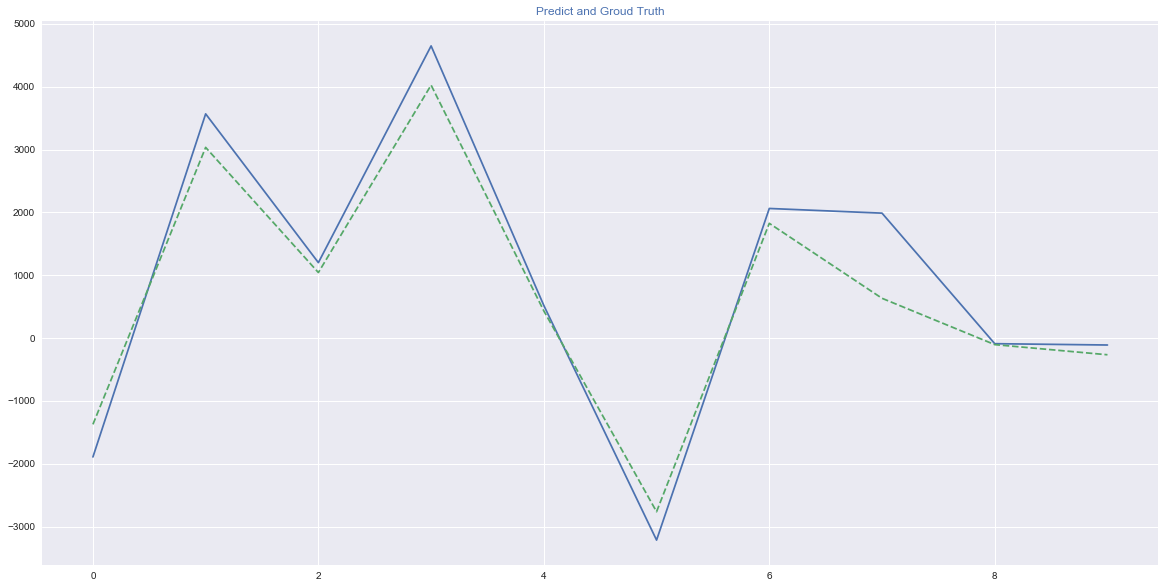

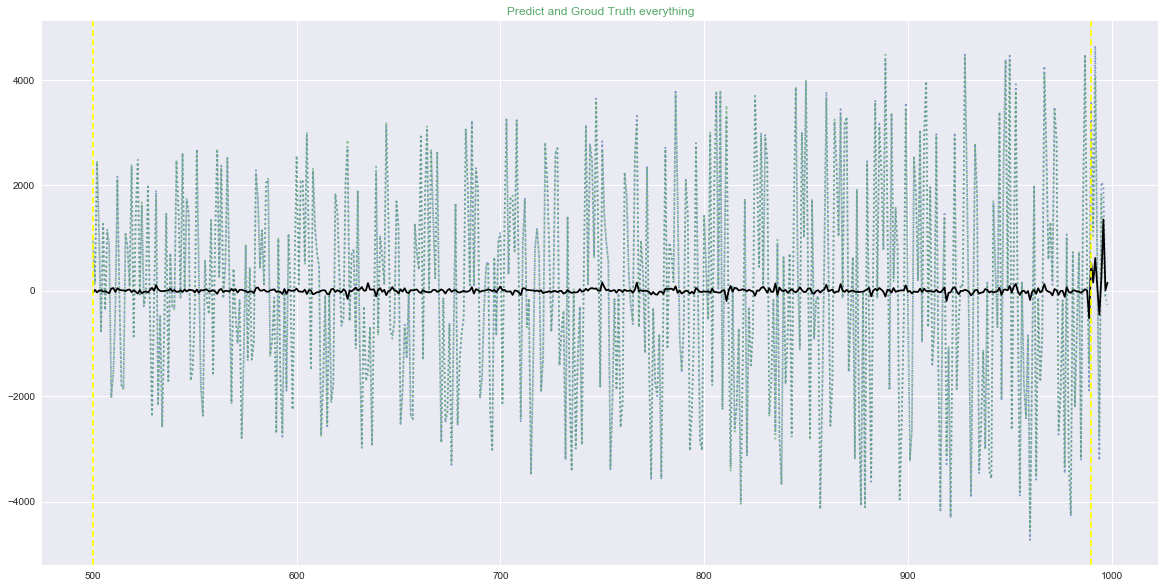

In [2]:
x_dim = 2000
connectivity = 0.09
spectral_radius = 0.9

u_num = 1000
u_dim = 5
u_mag = 5


leak = 1 # the bigger the more focused on present

cutout = 10
forget = 500

cv_start = 1
cv_end = 20
cv_step = 1
val_cut = 0.2

verbose = False

EchoStateTest(x_dim, connectivity, spectral_radius,
                u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose)

In [ ]:
x_dim = 2
u_num = 1000
u_dim = 20
u_mag = 4
cutout = 100

nans = np.random.randint(0,10, size=(x_dim, x_dim))
W = np.random.uniform(-100, 100, x_dim*x_dim).reshape([x_dim, x_dim])
W = np.where(nans, np.nan, W)
W = np.nan_to_num(W)
W = W / (np.linalg.svd(W)[1].tolist()[0]*1.2)


u = []
for i in range(u_dim):
    ui = []
    for j in range(u_num):
        ui.append(math.cos(i)*math.sin(j+i))
    ui = np.array(ui)
    u.append(ui)
#u = np.random.uniform(-u_mag, u_mag, u_num*u_dim).reshape([u_num, u_dim])
u = np.array(u).reshape(u_num, u_dim)


W_in = np.random.uniform(-5, 5, x_dim*u_dim).reshape([x_dim, u_dim])

W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

x_list = [np.zeros([x_dim])]


for i in range(u_num):
    x_next = np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1]))
    x_list.append(x_next)

states = np.array(x_list).reshape(u_num+1, x_dim)

    
    
# making fitting sequence
output = []
for j in range(u_num):
    output.append(10*math.cos(5)*math.sin(j+i))

    
    
    
    
output = np.array(output)
predictor = np.concatenate([u,  states[:-1,:]], axis =1)

print(output.shape)
print(predictor.shape)


print(predictor)

# making linear regression model
reg = Ridge(alpha=1).fit(predictor[cutout:u_num-cutout, :], output[cutout:u_num-cutout])


outhat = reg.predict(predictor[u_num-cutout:, :])
truth = output[u_num-cutout:]

"""
# 前面扔掉的100个，真实值与源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Original data and output'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout)], [output[j] for j in range(outhat.shape[0])])
for i in range(2):
    ax.plot([j for j in range(cutout)], [predictor[i][j] for j in range(outhat.shape[0])])
plt.show()



# 全部的，真实值与源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('input vs output before fitting'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout, u_num)], [output[j] for j in range(cutout, u_num)])
for i in range(20, 30):
    ax.plot([j for j in range(cutout, u_num)], [predictor[i][j] for j in range(cutout, u_num)])
plt.show() 
print((reg.coef_).tolist())


# 后面100个，真实值与预测的
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   
   
ax.plot([j for j in range(cutout)], [outhat[j] for j in range(outhat.shape[0])])
ax.plot([j for j in range(cutout)], [truth[j] for j in range(outhat.shape[0])])


# 所有的源数据
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('State Transition'.format("seaborn"), color='C0')   
   
for i in range(2):
    ax.plot([j for j in range(u_num)], [states[i][j] for j in range(u_num)])
        
plt.show() 




"""


mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('State Position'.format("seaborn"), color='C0')   
   
states = np.array(x_list).reshape(x_dim, u_num+1)
ax.scatter(states[0], states[1])
        
plt.show()


states = np.array(x_list).reshape(x_dim, u_num+1)




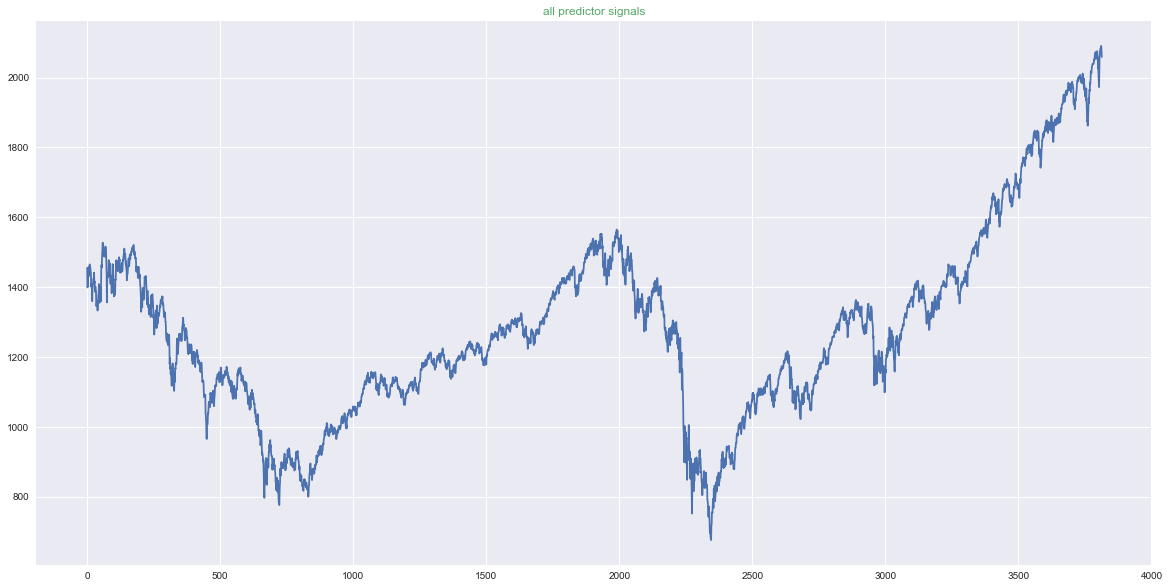

In [240]:
data = pd.read_csv("./SPX500.TXT", names = ["date", "open","high", "low", "close"], delimiter=" ", index_col =False)
data = data["close"].values




mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
ax.plot([j for j in range(data.shape[0])], data, )
